In [ ]:
!pip install mne # install mne
!pip install mat73 # install matlab version 7.3 loadmat

# library

In [ ]:
import os
import mne
import numpy as np
from numpy import angle, sin, cos, sqrt
# from scipy.io import loadmat
from mat73 import loadmat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
import matplotlib.pyplot as plt

# database

### Structure mne

### Average common reference

In [ ]:
# path of database
path = '../input/music-listening-experiment/Data 2/'
# subjects of database
Subjects = list(range(1,21))
gr = 3
if gr == 1:
    label = [1,2]
elif gr == 2:
    label = [1,3]
elif gr == 3:
    label = [2,3]
# save CAR
data_ref = list() 
y = list()
for Subject in Subjects:
    # name of archive
    if Subject < 10:
        filename = f'music_listening_experiment_s0'+str(Subject)+'.mat'
    else:
        filename = f'music_listening_experiment_s'+str(Subject)+'.mat'
    data_ = loadmat(path+filename)
    Data = data_['EEG_Songs']
    # Create some dummy metadata
    n_channels = len(data_['sensor_info']['labels'])
    sampling_freq = data_['Fs'] # in Hertz
    ch_names = [data_['sensor_info']['labels'][n][0].upper() for n in range(n_channels)]
    yt = data_['song_ratings']
    # selecionanando las características.
    if gr < 4:
        yt[yt == 3] = 2
        yt[yt == 5] = 3
        ind = yt == label[0]
        ind = ind + yt == label[1]
        Data = Data[ind,:,:]
        yt = yt[ind]
    # organizando los canales.
    for ch in range(n_channels):
        if ch_names[ch][0] == ' ':
            ch_names[ch] = ch_names[ch][1:]

    # structure
    ch_types = ['eeg']*n_channels
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage('standard_1020')
    
    window = 9.5*sampling_freq
    windows = list(np.arange(0,Data.shape[2]-window,window))
    cont = 0
    Y = list()
    Datos = np.zeros((int(Data.shape[0]*len(windows)),Data.shape[1],int(window)))
    for tri in range(Data.shape[0]):
        for tr in range(len(windows)):
            Datos[cont,:,:] = Data[tri,:,int(windows[tr]):int(windows[tr]+window)]
            Y.append(yt[tri])
            cont +=1
    y.append(np.asarray(Y))
    
    raw = mne.EpochsArray(Datos, info)

    # filtro la señal de 0.5 - 64 Hz.
    raw.filter(0.5,60)
    
    # CAR
    rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
    data_ref.append(rereferenced_raw.get_data())
y_ = np.asarray(y)

#  calculate-plot PSD en todo el tiempo del trial

In [ ]:
# Calculate PSD
nblock = 256
overlap = 100
win = hanning(nblock, True)
data_power = []
for sub in range(len(Subjects)):
  Power = list()
  for tr in range(data_ref[sub].shape[0]):
    freqs, Pxxf = welch(np.squeeze(data_ref[sub][tr,:,:]), sampling_freq, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)
    Power.append(Pxxf[:,1:49])
  data_power.append(np.asarray(Power))

Data_pow = np.asarray(data_power)
# savemat(path+'PSD.mat',{'Data_pow':Data_pow})

In [ ]:
# np.asarray(data_ref).shape
# data_ref[0].shape
# np.asarray(Power).shape
# Data_pow.shape

In [ ]:
# plt.semilogy(freqs, Pxxf.T)
# plt.grid()
# plt.show()

# Filter

In [ ]:
#filtering functions
def butter_bandpass(lowcut, highcut, fs, order=4):
  #lowcut is the lower bound of the frequency that we want to isolate
  #hicut is the upper bound of the frequency that we want to isolate
  #fs is the sampling rate of our data
  nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
  low = float(lowcut) / nyq
  high = float(highcut) / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

##
def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, mydata)
  return y

# PSD por ventanas de tiempo

In [ ]:
# Calculate PSD
# nblock = 128
# win = hanning(nblock, True)
# window = 1*sampling_freq
# step = 0.1*sampling_freq
# windows = list(np.arange(0,data_ref[0].shape[2]-window,step))
# data_power_ = list()

# for sub in range(len(Subjects)):
#     Power = list()
#     for tr in range(data_ref[sub].shape[0]):
#         Power_ven = list()
#         for ven in range(len(windows)-1):
#             freqs, Pxxf = welch(np.squeeze(data_ref[sub][tr,:,int(windows[ven]):int(windows[ven]+window)]), sampling_freq, window=win,  nfft=nblock, return_onesided=True, scaling='spectrum')
#             Power_ven.append(Pxxf[:,1:49])
#         Power.append(np.asarray(Power_ven))
#     data_power_.append(np.asarray(Power))
# Data_pow = np.asarray(data_power_)

In [ ]:
freqs[1:49]

In [ ]:
from scipy.io import loadmat as loadmat2
if gr == 1:
    resultado_j = loadmat2('../input/resultados-de-main-music-gr/Main2_music2_gr1.mat')
    Acc_ =  np.max(resultado_j['facc_'],axis=1)
    Acc_.shape
elif gr == 2:
    resultado_j = loadmat2('../input/resultados-de-main-music-gr/Main2_music2_gr2.mat')
    Acc_ =  np.max(resultado_j['facc_'],axis=1)
    Acc_.shape
elif gr == 3:
    resultado_j = loadmat2('../input/resultados-de-main-music-gr/Main2_music2_gr3.mat')
    Acc_ =  np.max(resultado_j['facc_'],axis=1)
    Acc_.shape
else:
    resultado_j = loadmat2('../input/main2music3/Main2_music3.mat')
    Acc_ =  np.max(resultado_j['facc_'],axis=1)
    Acc_.shape

In [ ]:
met = 1
# Acc = np.zeros()
if met == 1:
    Acc = Acc_
    datos = np.reshape(Data_pow,(Data_pow.shape[0],Data_pow.shape[1]*
                               Data_pow.shape[2]*Data_pow.shape[3]))
elif met == 2:
    # datos = np.zeros((21,912000))
    Acc = np.zeros((21,1))
    index = list()
    for sub in range(len(Acc_)):
        index.append(resultado_j['facc_'][sub,:]>=Acc_[sub])
        index_ = np.sum(np.asarray(index),axis=0).reshape(-1,1).T>10
        Acc = np.mean(resultado_j['facc_'][:,index_.reshape(-1)],axis=1)
        datos_ = Data_pow[:,:,index_.reshape(-1),:,:]
        datos = np.reshape(datos_,(datos_.shape[0],datos_.shape[1]*datos_.shape[2]*
                                 datos_.shape[3]*datos_.shape[4]))
else:
    datos = np.zeros((21,912000))
    Acc = np.zeros((21,1))
    index = list()
    tam = list()
    for sub in range(len(Acc_)):
        index_ = resultado_j['facc_'][sub,:]>=Acc_[sub]
        Acc[sub] = np.mean(resultado_j['facc_'][sub,index_])
        datos_ = Data_pow[sub,:,index_.reshape(-1),:,:]
        temp = np.reshape(datos_,(datos_.shape[0]*datos_.shape[1]*datos_.shape[2]*
                                 datos_.shape[3]))
        tam.append(temp.shape)
        datos[sub,0:temp.shape[0]] = temp

In [ ]:
del Data_pow

# Regression

In [ ]:
XT = datos
YT = Acc.reshape(-1,1) # agrego el acc de los sujetos
YT.shape
del datos

In [ ]:
#----------------------------------------------------------------------------------------------------------------
ind_YT = np.argsort(Acc).reshape(-1)
# for each sample (row) we apply min-max transformation
XT_norm_ = np.zeros((XT.shape))
for k in range(XT.shape[0]):
  XT_norm_[k,:] = (XT[k,:]-XT[k,:].min())/(XT[k,:].max()-XT[k,:].min())
XT_norm = XT_norm_[ind_YT,:]
#----------------------------------------------------------------------------------------------------------------
# for each sample (row) we apply min-max transformation
# YTa = np.zeros((YT_.shape))
# for k in range(YT_.shape[0]):
#   YTa[k,:] = (YT_[k,:]-YT_[k,:].min())/(YT_[k,:].max()-YT_[k,:].min())
# YT = YTa[ind_YT,:]
YT = YT[ind_YT]
YT.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# data loading scaling, splitting
# validation subject
best_ = list()
results_ = list()

scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
# 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
# se utilizaron para entrenamiento y el último de validación 
# clases de la base de datos.
y = YT
# PSD
X = XT_norm
# PAC in the time.
# dat = np.squeeze()
# X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
# Grid_s = list()
# for i in range(50):
# print(f'fold '+str(i))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
# shuffle_split = StratifiedKFold(n_splits=2, random_state=0, shuffle=False)
# cv = 
steps = [('Reg', SVR(kernel='rbf'))]
pipe_svr = Pipeline(steps)
params_grid={
          'Reg__C': [0.01, 0.1, 1, 100, 1000],
          'Reg__gamma':[0.01, 0.1, 1, 100, 1000]
          }

grid = GridSearchCV(estimator=pipe_svr, 
                  param_grid=params_grid, 
                  scoring=scorer,
                  cv =shuffle_split,
                  # LeaveOneOut(),
                  error_score='raise',
                  verbose=20)

grid.fit(X,y.ravel())
results_.append(grid.best_estimator_.predict(X))#(grid.cv_results_)
best_.append(grid.best_estimator_)

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

# PAC %estimation of phase-amplitude cross-frequency coupling

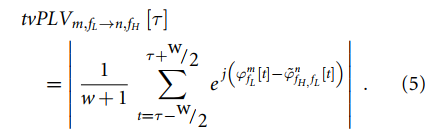

In [ ]:
def moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq):
  #calculating phase of theta
  phase_data = butter_bandpass_filter(data1, fr1[0], fr1[1],(sampling_freq))
  phase_data = angle(hilbert(phase_data))

  #calculating amplitude envelope of high gamma
  amp_data = butter_bandpass_filter(data2, fr2[0], fr2[1], (sampling_freq))
  amp_data = abs(hilbert(amp_data))

  # Filtering the amplitude of analytic signal of the high-frequency range within the
  # frequency range of the low-frequency band
  lowfromhigh = butter_bandpass_filter(amp_data, fr1[0], fr1[1],(sampling_freq))
  
  # lowfromhigh.shape
  low_Env_high_filtered_signals = lowfromhigh-np.tile(np.mean(lowfromhigh),(Ntrials,1))
  
  # get the phase
  Amp_phase_signals=angle(hilbert(low_Env_high_filtered_signals))
  Ntime = data1.shape[1]
  Nstep = np.floor(Ntime/Nsegments)
  temporal_ = np.zeros((Nsegments))
  for ii in range(Nsegments): # repear over different segments
    start = np.floor((ii)*Nstep).astype(int)
    stop  = np.floor((ii+1)*Nstep).astype(int)
    plv = np.abs(np.sum(np.sum(np.exp(1j*(phase_data[:,start:stop]-Amp_phase_signals[:,start:stop]))))/(Ntrials*(Nstep)))
    temporal_[ii]=plv
  return temporal_

In [ ]:
from numpy import angle, sin, cos, sqrt
def moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq,type):
    #calculating phase of theta
    phase_data = butter_bandpass_filter(data1, fr1[0], fr1[1],(sampling_freq))
    phase_data = angle(hilbert(phase_data))

    #calculating amplitude envelope of high gamma
    amp_data = butter_bandpass_filter(data2, fr2[0], fr2[1], (sampling_freq))
    amp_data = abs(hilbert(amp_data))

    # Filtering the amplitude of analytic signal of the high-frequency range within the
    # frequency range of the low-frequency band
    lowfromhigh = butter_bandpass_filter(amp_data, fr1[0], fr1[1],(sampling_freq))

    # lowfromhigh.shape
    low_Env_high_filtered_signals = lowfromhigh-np.tile(np.mean(lowfromhigh),(Ntrials,1))

    # get the phase
    Amp_phase_signals=angle(hilbert(low_Env_high_filtered_signals))
    Ntime = 1*sampling_freq #data1.shape[1]
    Nstep = 0.1*sampling_freq
    windows = list(np.arange(0,data_ref[0].shape[2]-window,step))
    Nsegments = len(windows)

    if type == 'trials':
        temporal_ = np.zeros((Amp_phase_signals.shape[0],Nsegments))
    else:
        temporal_ = np.zeros((Nsegments))
    for ii in range(Nsegments): # repear over different segments
        start = int(windows[ii])
        stop  = int(windows[ii]+Ntime)
        if type == 'trials':
            plv = np.abs(np.sum(np.exp(1j*(phase_data[:,start:stop]-Amp_phase_signals[:,start:stop])),axis=1)/((Nstep)))
            temporal_[:,ii]=plv
        else:
            plv = np.abs(np.sum(np.sum(np.exp(1j*(phase_data[:,start:stop]-Amp_phase_signals[:,start:stop]))))/(Ntrials*(Nstep)))
            temporal_[ii]=plv
    return temporal_

In [ ]:
# Parameters
# Bands of rytms: delta to gamma.
phase_providing_band = [[8,12]]
amplitude_providing_band = [[8,12]]
Ntrials   = data_ref[0].shape[0]
Nsegments = 85 # Number of segments in window.
Nchannels = data_ref[0].shape[1]
Nfreqs    = len(phase_providing_band)

In [ ]:
#@title Texto de título predeterminado
# temporal_plv = np.zeros((len(Subjects),int(Nchannels*(Nchannels-1)/2),Nfreqs,Nfreqs,Nsegments))
temporal_plv = np.zeros((len(Subjects),Ntrials,int(Nchannels*(Nchannels-1)/2),Nfreqs,Nfreqs,Nsegments))
# (Nodes,Nodes,Time)
Nsegments = 85
for sub in range(len(Subjects)):
    cont_ch = 0 # contador de las subredes
    for ch1 in range(Nchannels):
        for ch2 in range(ch1+1,Nchannels-1):
            if ch1 != ch2:
                data1= np.squeeze(data_ref[sub][:,ch1,:])
                data2= np.squeeze(data_ref[sub][:,ch2,:])
            fr_1 = 0
            for fr1 in phase_providing_band:
                fr_2 = 0
                for fr2 in amplitude_providing_band:
                # temporal_plv[sub,cont_ch,fr_1,fr_2,:] = moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq)
                    temporal_plv[sub,:,cont_ch,fr_1,fr_2,:] = moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq,type='trials')
                    fr_2 += 1
                fr_1 += 1
            cont_ch += 1
  # savemat(load_path+f'PLV_pac'+str(sub)+'_trials.mat',{'temporal_plv':temporal_plv})

In [ ]:
# PAC 
temporal_plv_ = np.squeeze(temporal_plv)
temporal_plv_.shape

In [ ]:
met = 1
# Acc = np.zeros()
if met == 1:
    Acc = Acc_
    datos = np.reshape(temporal_plv_,(temporal_plv_.shape[0],temporal_plv_.shape[1]*
                               temporal_plv_.shape[2]*temporal_plv_.shape[3]))
elif met == 2:
    # datos = np.zeros((21,912000))
    Acc = np.zeros((21,1))
    index = list()
    for sub in range(len(Acc_)):
        index.append(resultado_j['facc_'][sub,:]>=Acc_[sub])
        index_ = np.sum(np.asarray(index),axis=0).reshape(-1,1).T>10
        Acc = np.mean(resultado_j['facc_'][:,index_.reshape(-1)],axis=1)
        datos_ = Data_pow[:,:,index_.reshape(-1),:,:]
        datos = np.reshape(datos_,(datos_.shape[0],datos_.shape[1]*datos_.shape[2]*
                                 datos_.shape[3]*datos_.shape[4]))
else:
    datos = np.zeros((21,912000))
    Acc = np.zeros((21,1))
    index = list()
    tam = list()
    for sub in range(len(Acc_)):
        index_ = resultado_j['facc_'][sub,:]>=Acc_[sub]
        Acc[sub] = np.mean(resultado_j['facc_'][sub,index_])
        datos_ = Data_pow[sub,:,index_.reshape(-1),:,:]
        temp = np.reshape(datos_,(datos_.shape[0]*datos_.shape[1]*datos_.shape[2]*
                                 datos_.shape[3]))
        tam.append(temp.shape)
        datos[sub,0:temp.shape[0]] = temp

In [ ]:
XT = datos
YT = Acc.reshape(-1,1) # agrego el acc de los sujetos
YT.shape
del datos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# data loading scaling, splitting
# validation subject
best_ = list()
results_ = list()

scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
# 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
# se utilizaron para entrenamiento y el último de validación 
# clases de la base de datos.
y = YT
# PSD
X = XT_norm
# PAC in the time.
# dat = np.squeeze()
# X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
# Grid_s = list()
# for i in range(50):
# print(f'fold '+str(i))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
# shuffle_split = StratifiedKFold(n_splits=2, random_state=0, shuffle=False)
# cv = 
steps = [('Reg', SVR(kernel='rbf'))]
pipe_svr = Pipeline(steps)
params_grid={
          'Reg__C': [0.01, 0.1, 1, 100, 1000],
          'Reg__gamma':[0.01, 0.1, 1, 100, 1000]
          }

grid = GridSearchCV(estimator=pipe_svr, 
                  param_grid=params_grid, 
                  scoring=scorer,
                  cv =shuffle_split,
                  # LeaveOneOut(),
                  error_score='raise',
                  verbose=20)

grid.fit(X,y.ravel())
results_.append(grid.best_estimator_.predict(X))#(grid.cv_results_)
best_.append(grid.best_estimator_)

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = YT,results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

# Dinamic graph centrality measure

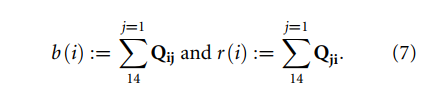

In [ ]:
## Contact Sequen
def arrayToContactSeq(adjArray,isdirected):
  # % arrayToContactSeq takes a sequence of matrices and converts this to a
  # % long format contact sequence.
  # %
  # % Inputs:
  # %       adjArray = an nNodes x nNodes x time-points array encoding a
  # %           dynamic network
  # %       isdirected = boolean indicating if the network is directed
  # %
  # % Output:
  # %       contactSequence = nEdges x 3 array of (i,j,t) tuples indicating
  # %           contact between nodes i,j at time t. If adjArray is weighted,
  # %           this will be an nEdges x 4 array of (i,j,t,w) including the
  # %           edge weight w.
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  nNodes = adjArray.shape[0]
  contactSequence = []
  for t in range(adjArray.shape[2]):
    if not isdirected:
      for i in range(nNodes):
        for j in range(i+1,nNodes):
          if adjArray[i,j,t] != 0:
              contactSequence.append([i, j, t, adjArray[i,j,t]])
    else:
      for i in range(nNodes):
        for j in range(i+1,nNodes):
          if i != j:
            if adjArray[i,j,t] != 0:
              contactSequence.append([i, j, t, adjArray[i,j,t]])
              
  contactSequence  = np.asarray(contactSequence)            
  # if it is unweighted, return only the first three columns
  if len(np.unique(contactSequence[:,3])) == 1:
    contactSequence = contactSequence[:,0:3]

  return contactSequence

## Networks
def networksFromContacts(contactSequence,directed):
  # % networksFromContacts creates an array of networks (weighted or binary)
  # % from a contact sequence.
  # %
  # % Input:
  # %       contactSequence = nEdges x 3 matrix encoding contacts between node
  # %           i,j at time t by (i,j,t). Optionally a fourth column denotes 
  # %           edge weight.
  # %       directed = 1 for creating a directed network, 0 otherwise.
  # %
  # % Output: 
  # %       adjArray = nNodes x nNodes x nTimes array describing binary or
  # %           weighted network at each time point.
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  times = np.unique(contactSequence[:,2])
  nNodes = np.unique([contactSequence[:,0], contactSequence[:,1]]).shape[0]
  adjArray = np.zeros((nNodes,nNodes,len(times)))

  if contactSequence.shape[1] == 3:
    edgeWeights = np.ones((contactSequence.shape[0],1))
  else:
    edgeWeights = contactSequence[:,3]
  
  for t in range(len(times)):
    edges = np.where(contactSequence[:,2] == times[t])[0]
    nodes = np.squeeze(contactSequence[edges,0:2]).astype(int)
    
    for i in range(nodes.shape[0]):
      if nodes.shape[0] == 1:
        adjArray[nodes[0],nodes[1],t] = edgeWeights[edges[i]]
        if not directed:
          adjArray[nodes[1],nodes[0],t] = edgeWeights[edges[i]]
      else:
        adjArray[nodes[i,0],nodes[i,1],t] = edgeWeights[edges[i]]
        if not directed:
          adjArray[nodes[i,1],nodes[i,0],t] = edgeWeights[edges[i]]

  return adjArray

## Threshold matrix at a given edge density.
def thresholdMatDensity(adj,density):
  # record and sort edges in decreasing order
  edges = np.concatenate(adj,axis=0)
  sortedEdges = np.flip(np.sort(edges))
  nEdges = len(edges)
  
  # Calculate threshold
  threshold = sortedEdges[int(np.ceil(nEdges*density))]

  # Threshold matrix
  tadj = adj
  tadj[tadj<threshold] = 0
  
  return tadj, threshold 

## Calculate the broadcast and receive centrality as defined in Mantzaris et al. 2013.
def broadcastRecieveCentrality(contactSequence,alpha, nNodes=None):
  # % Inputs:
  # %       contactSequence = nEdges x 3 array of (i,j,t) tuples indicating
  # %           contact between nodes i,j at time t. Assumes undirected.
  # %       alpha = scalar in (0,1) governing weight given to paths based on
  # %           the number of edges.
  # %
  # % Optional Inputs:
  # %       nNodes = number of nodes in the dynamic network. Default is all
  # %           nodes which appear in contactSequence (have at least one
  # %           contact).
  # %
  # % Outputs:
  # %       broadcastCentrality = nNodes x 1 vector recording the broadcast
  # %           centrality at each node.
  # %       receiveCentrality = nNodes x 1 vector recording the receive
  # %           centrality at each node.
  # %
  # % 
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  if nNodes == None:
    nNodes = np.unique([contactSequence[:,0], contactSequence[:,1]]).shape[0]
  
  # convert contact sequence to array of networks
  directed = 0
  adjArray = networksFromContacts(contactSequence,directed)
  badj = adjArray[:,:,0]
  badj[badj>0] = 1
  P_sd = np.linalg.inv(np.eye(nNodes) - alpha*badj)
  nTimes = adjArray.shape[2]
  
  for n in range(1,nTimes):
    [badj,threshold] = thresholdMatDensity(adjArray[:,:,n],0.1)
    badj[badj>0] = 1
    P_sd = P_sd.dot(np.linalg.inv(np.eye(nNodes) - alpha*badj))
  
  # # 
  Q_sd = P_sd/np.linalg.norm(P_sd);
  #
  broadcastCentrality = np.sum(Q_sd,axis=1).reshape(-1,1)
  receiveCentrality = np.sum(Q_sd,axis=0).reshape(1,-1)
  
  return broadcastCentrality,receiveCentrality

In [ ]:
# ArrayToContactSeq takes a sequence of matrices and converts this to a
broadcastCentrality = []
receiveCentrality = []
alpha = 0.1
load(path+f'PLV_pac19.mat')
for sub in range(1): #len(Subjects)
  temp1,temp2 = [],[]
  for cont_ch in range(91):
    # long format contact sequence.
    contactSequence = arrayToContactSeq(temporal_plv[sub,cont_ch,fr_1,fr_2,:],0)
    # 
    [broad,receive] = broadcastRecieveCentrality(contactSequence,alpha)
    temp1.append(broad)
    temp2.append(receive)
  broadcastCentrality.append(temp1)
  receiveCentrality.append(temp2)

# Regression

In [ ]:
# librerias para sklearn SFS
# !pip install -U scikit-learn
# !pip install -U SciPy
# !pip install -U NumPy
# !pip install -U matplotlib
# !pip install -U Joblib
# !pip install -U threadpoolctl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# data loading scaling, splitting
# validation subject
results_ = list()
best_    = list()
for sub in range(len(Subjects)):
    scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
    # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
    # se utilizaron para entrenamiento y el último de validación 
    # clases de la base de datos.
    y = y_[sub,:].reshape(-1,1)
    # PSD.
    dat = np.squeeze(Data_pow[sub,:,:,:])
    X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    # PAC in the time.
    # dat = np.squeeze()
    # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    # Grid_s = list()
    # for i in range(50):
    # print(f'fold '+str(i))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
    shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
    steps = [('Reg', SVR(kernel='rbf'))]
    pipe_svr = Pipeline(steps)
    params_grid={
              'Reg__C': [0.01, 0.1, 1, 10, 100, 1000],
              'Reg__gamma':[0.01, 0.1, 1, 10, 100, 1000]
              }

    grid = GridSearchCV(estimator=pipe_svr, 
                      param_grid=params_grid, 
                      scoring=scorer,
                      cv =shuffle_split,
                      error_score='raise',
                      verbose=0)

    
    grid.fit(X,y.ravel())
    results_.append(grid.best_estimator_.predict(X)) #(grid.cv_results_)
    best_.append(grid.best_estimator_)

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = y_[sub,:].reshape(-1,1),results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(np.arange(1,21),R2)
plt.ylim([0,1])
plt.xticks(np.arange(1,21),np.arange(1,21))
plt.title(f'Prueba PSD Sin Scaler Media: '+str(round(np.mean(R2),2)))
plt.savefig('/kaggle/working/PSD_sin_scater_D2.png')

# prueba con KPCA

In [ ]:
Data_pow.shape

# KPCA tomando 2 componentes, aplicando a los datos StandardScaler por cada sujeto

In [ ]:
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(4,5, figsize=(20, 20))

for sub in range(len(Subjects)):
    dat = np.squeeze(Data_pow[sub,:,:,:])
    X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    red = KPCA(n_components=2,kernel='rbf',gamma=best_[sub].steps[0][1].gamma)
    Y = red.fit_transform(StandardScaler().fit_transform(X))
    if sub<5:
        scatter = ax[0,sub].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[0,sub].set_xlim([-0.6,0.8])
        ax[0,sub].set_ylim([-0.8,0.8])
        ax[0,sub].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=5 and sub <10:
        scatter = ax[1,sub-5].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[1,sub-5].set_xlim([-0.6,0.8])
        ax[1,sub-5].set_ylim([-0.8,0.8])
        ax[1,sub-5].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=10 and sub <15:
        scatter = ax[2,sub-10].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[2,sub-10].set_xlim([-0.6,0.8])
        ax[2,sub-10].set_ylim([-0.8,0.8])
        ax[2,sub-10].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=15 and sub <20:
        scatter = ax[3,sub-15].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[3,sub-15].set_xlim([-0.6,0.8])
        ax[3,sub-15].set_ylim([-0.8,0.8])
        ax[3,sub-15].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    
#     plt.scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
#     ax[pos].legend(handles=scatter.legend_elements()[0], labels=('1','2','3','4'))
      # X_transformed = transformer.fit_transform(StandardScaler().fit_transform(X))
      # plt.imshow(X_transformed,aspect = 'auto')
#       plt.colorbar()
    fig.suptitle(f'Sujetos '+str(sub+1)+' 2 características selecionadas por KPCA con StandarScaler de la PSD')
#     ax[pos].show()

In [ ]:
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(4,5, figsize=(20, 20))

for sub in range(len(Subjects)):
    dat = np.squeeze(Data_pow[sub,:,:,:])
    X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    red = KPCA(n_components=2,kernel='rbf',gamma=best_[sub].steps[0][1].gamma)
    Y = red.fit_transform(StandardScaler().fit_transform(X))
    if sub<5:
        scatter = ax[0,sub].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[0,sub].set_xlim([-0.6,0.8])
        ax[0,sub].set_ylim([-0.8,0.8])
        ax[0,sub].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=5 and sub <10:
        scatter = ax[1,sub-5].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[1,sub-5].set_xlim([-0.6,0.8])
        ax[1,sub-5].set_ylim([-0.8,0.8])
        ax[1,sub-5].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=10 and sub <15:
        scatter = ax[2,sub-10].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[2,sub-10].set_xlim([-0.6,0.8])
        ax[2,sub-10].set_ylim([-0.8,0.8])
        ax[2,sub-10].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    elif sub>=15 and sub <20:
        scatter = ax[3,sub-15].scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
        ax[3,sub-15].set_xlim([-0.6,0.8])
        ax[3,sub-15].set_ylim([-0.8,0.8])
        ax[3,sub-15].legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
    
#     plt.scatter(Y[:,0],Y[:,1],c=y_[sub,:].reshape(-1,1))
#     ax[pos].legend(handles=scatter.legend_elements()[0], labels=('1','2','3','4'))
      # X_transformed = transformer.fit_transform(StandardScaler().fit_transform(X))
      # plt.imshow(X_transformed,aspect = 'auto')
#       plt.colorbar()
    fig.suptitle(f'Sujetos '+str(sub+1)+' 2 características selecionadas por KPCA con StandarScaler de la PSD')
#     ax[pos].show()

# KPCA tomando 2 componentes, aplicando a los datos StandardScaler tomando todos los sujetos

In [ ]:
X = []
y = []
for sub in range(len(Subjects)):
    dat = np.squeeze(Data_pow[sub,:,:,:])
    X.append(np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2])))
    y.append(y_[sub,:].reshape(-1,1))
X = np.concatenate(X,axis=0)
y = np.concatenate(y,axis=0)
# X.shape
red = KPCA(n_components=2,kernel='rbf',gamma=best_[sub].steps[0][1].gamma)
Y = red.fit_transform(StandardScaler().fit_transform(X))
scatter = plt.scatter(Y[:,0],Y[:,1],c=y)
# ax[0,sub].set_xlim([-0.6,0.8])
# ax[0,sub].set_ylim([-0.8,0.8])
plt.legend(handles=scatter.legend_elements()[0], labels=('1','2','3'))
plt.title('Sujetos ')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# data loading scaling, splitting
# validation subject
results_ = list()
best_    = list()
for sub in range(len(Subjects)):
    scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
    # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
    # se utilizaron para entrenamiento y el último de validación 
    # clases de la base de datos.
    y = y_[sub,:].reshape(-1,1)
    # PSD.
    dat = np.squeeze(Data_pow[sub,:,:,:])
    X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    # PAC in the time.
    # dat = np.squeeze()
    # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    # Grid_s = list()
    # for i in range(50):
    # print(f'fold '+str(i))
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
    shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
    steps = [('Scaler',StandardScaler()),
             ('Reg', SVR(kernel='rbf'))]
    pipe_svr = Pipeline(steps)
    params_grid={
              'Reg__C': [0.01, 0.1, 1, 10, 100, 1000],
              'Reg__gamma':[0.01, 0.1, 1, 10, 100, 1000]
              }

    grid = GridSearchCV(estimator=pipe_svr, 
                      param_grid=params_grid, 
                      scoring=scorer,
                      cv =shuffle_split,
                      error_score='raise',
                      verbose=0)

    
    grid.fit(X,y.ravel())
    results_.append(grid.best_estimator_.predict(X)) #(grid.cv_results_)
    best_.append(grid.best_estimator_)

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_true,y_pred = y_[sub,:].reshape(-1,1),results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(np.arange(1,21),R2)
plt.ylim([0,1])
plt.xticks(np.arange(1,21),np.arange(1,21))
plt.title(f'Prueba PSD Con Scaler Media: '+str(round(np.mean(R2),2)))
plt.savefig('/kaggle/working/PSD_con_scater_D2.png')

# Leave subject out

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# data loading scaling, splitting
# validation subject
results_    = list()
best_       = list()
indices_sub = [np.ones((30,1))*i for i in range(len(Subjects))]
indices_sub = np.concatenate(indices_sub,axis=0)
X_tr = list()
for sub_test in Subjects:
    # todos los trials de los sujetos leave subjects out
    # se utilizaron para entrenamiento y el último de validación 
    # clases de la base de datos.
    # PSD.
    X_tr = list()
    y_tr = list()
    Subjects_train= Subjects[:]
    Subjects_train.pop(Subjects_train.index(sub_test))
    for sub in Subjects_train:
        dat = np.squeeze(Data_pow[sub-1,:,:,:])
        X_tr.append(np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2])))
        y_tr.append(y_[sub-1,:].reshape(-1,1))
    X_tr = np.concatenate(X_tr,axis=0)
    dat  = np.squeeze(Data_pow[sub_test-1,:,:,:])
    X_te = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
    y_tr = np.concatenate(y_tr,axis=0)
#     shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)

    scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
    steps = [('Reg', SVR(kernel='rbf'))]
    pipe_svr = Pipeline(steps)
    params_grid={
              'Reg__C': [0.01, 0.1, 1, 10, 100, 1000],
              'Reg__gamma':[0.01, 0.1, 1, 10, 100, 1000]
              }

    grid = GridSearchCV(estimator=pipe_svr, 
                      param_grid=params_grid, 
                      scoring=scorer,
                      cv =10,
                      error_score='raise',
                      verbose=10,n_jobs=-1)
#     pos_tr = indices_sub!=sub-1
    grid.fit(X_tr,y_tr.ravel())
    results_.append(grid.best_estimator_.predict(X_te)) #(grid.cv_results_)
    best_.append(grid.best_estimator_)

In [ ]:
MAE = list()
R2  = list()
for sub in range(len(best_)):
    y_te = y_[sub,:].reshape(-1,1)
    y_true,y_pred = y_te.reshape(-1,1),results_[sub]
    mae = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub+1,mae=mae,r2=r2))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(MAE),r2=np.mean(R2)))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(np.arange(1,21),R2)
plt.ylim([0,1])
plt.xticks(np.arange(1,21),np.arange(1,21))
plt.title(f'Prueba PSD Sin Scaler all Media: '+str(round(np.mean(R2),2)))
plt.savefig('/kaggle/working/PSD_sin_scater_all_D2.png')

# KPCA y TSNE

In [ ]:
# transformer = KernelPCA()
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

X_tr = list()
y_tr = list()
for sub in range(len(Subjects)):
  dat = np.squeeze(Data_pow[sub,:,:,:])
  y_tr.append(y_[sub,:].reshape(-1,1))
  X_tr.append(np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2])))
X_tr = np.concatenate(X_tr,axis=0)
y_tr = np.concatenate(y_tr,axis=0)
a = -1
b = 1
for tr in range(X_tr.shape[0]):
  min_ = np.min(X_tr[tr,:])
  max_ = np.max(X_tr[tr,:])  
  X_tr[tr,:] = a+((X_tr[tr,:]-min_)*(b-a))/(max_-min_)
red = KPCA(n_components=2)
# Y = red.fit_transform(StandardScaler().fit_transform(X_tr))
# Y = red.fit_transform(MinMaxScaler().fit_transform(X_tr.T).T)
Y = red.fit_transform(X_tr)

In [ ]:
plt.figure(figsize=(20, 20))
index_sub = np.concatenate([(i+1)*np.ones((12,1)) for i in range(21)],axis=0).reshape(-1)
for i in range(21): 
  plt.scatter(Y[i*12:12+(i*12),0],Y[i*12:12+(i*12),1])
# plt.set_xlim([-0.6,0.8])
# plt.set_ylim([-0.8,0.8])
# plt.set_title(str(sub+1))
# plt.legend(handles=ax.legend_elements()[0], labels=tuple(np.arange(1,21)))
# ax.legend(labels=tuple(index_sub))

for i, txt in enumerate(list(y_tr.reshape(-1))):
    plt.annotate(txt, (Y[i,0], Y[i,1]))

plt.legend(list(np.arange(1,22)))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
X_tr = list()
y_tr = list()
for sub in range(len(Subjects)):
  dat = np.squeeze(Data_pow[sub,:,:,:])
  y_tr.append(y_[sub,:].reshape(-1,1))
  X_tr.append(np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2])))
X_tr = np.concatenate(X_tr,axis=0)
y_tr = np.concatenate(y_tr,axis=0)
red = TSNE(n_components=2, perplexity=5)
# Y = red.fit_transform(StandardScaler().fit_transform(X_tr))
Y = red.fit_transform(MinMaxScaler().fit_transform(X_tr.T).T)

In [ ]:
plt.figure(figsize=(20, 20))
index_sub = np.concatenate([(i+1)*np.ones((12,1)) for i in range(21)],axis=0).reshape(-1)
for i in range(21):
    plt.scatter(Y[i*12:12+(i*12),0],Y[i*12:12+(i*12),1])
# plt.set_xlim([-0.6,0.8])
# plt.set_ylim([-0.8,0.8])
# plt.set_title(str(sub+1))
# plt.legend(handles=ax.legend_elements()[0], labels=tuple(np.arange(1,21)))
# ax.legend(labels=tuple(index_sub))

for i, txt in enumerate(list(y_tr.reshape(-1))):
    plt.annotate(txt, (Y[i,0], Y[i,1]))

plt.legend(list(np.arange(1,22)))
plt.show()